# Investigating the output of neural net embedding subnets

## Aims

* To investigate the output of the hospital and clinical subnets of the embedding neural network.

* To examine the link between hospital subnet output and use of thrombolysis in hospitals - both the actual thrombolysis use, and the predicted thrombolysis use of a 10k set of patients passed through all hospital models.

* To examine the link between the patient clinical feature subnet output and the use of thrombolysis, and the link between patient features and the clinical feature subnet output

## Neural Network structure

The model contains three subnets that take portions of the data. The output of these subnets is an n-dimensional vector. In this case the output is a 1D vector, that is each subnet is reduced to a single value output. The subnets created are for:

1. *Patient clinical data*: Age, gender, ethnicity, disability before stroke, stroke scale data. Pass through one hidden layer (with 2x neurons as input features) and then to single neuron with sigmoid activation.

2. *Pathway process data*: Times of arrival and scan, time of day, day of week. Pass through one hidden layer (with 2x neurons as input features) and then to single neuron with sigmoid activation.

3. *Hospital ID* (one-hot encoded): Connect input directly to single neuron with sigmoid activation.

The outputs of the three subnet outputs are then passed to a single neuron with sigmoid activation for final output.

![](./images/subnets.png)

## Fitting of model

The model has been pre-trained (see the notebook *Modular TensorFlow model with 1D embedding - Train and save model for 10k patient subset*)

## Load libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

2022-01-09 13:03:27.193351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Define function to scale data

Scale input data 0-1 (MinMax scaling).

In [2]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Get model outputs for test data

Get prediction probabilities for the test 10k training set. Training data is used only to scale test set X values.

This prediction run is used to check model, and get accuracy.

In [5]:
# Load data
train = pd.read_csv(f'../../data/sam_1/10k_training_test/cohort_10000_train.csv')
test = pd.read_csv(f'../../data/sam_1/10k_training_test/cohort_10000_test.csv')

# Get data subgroups
subgroups = pd.read_csv('../../data/sam_1/subnet.csv', index_col='Item')
# Get list of clinical items
clinical_subgroup = subgroups.loc[subgroups['Subnet']=='clinical']
clinical_subgroup = list(clinical_subgroup.index)
# Get list of pathway items
pathway_subgroup = subgroups.loc[subgroups['Subnet']=='pathway']
pathway_subgroup = list(pathway_subgroup.index)
# Get list of hospital items
hospital_subgroup = subgroups.loc[subgroups['Subnet']=='hospital']
hospital_subgroup = list(hospital_subgroup.index)

# OneHot encode stroke team
coded = pd.get_dummies(train['StrokeTeam'])
train = pd.concat([train, coded], axis=1)
train.drop('StrokeTeam', inplace=True, axis=1)
coded = pd.get_dummies(test['StrokeTeam'])
test = pd.concat([test, coded], axis=1)
test.drop('StrokeTeam', inplace=True, axis=1)

# Split into X, y
X_train_df = train.drop('S2Thrombolysis',axis=1) 
y_train_df = train['S2Thrombolysis']
X_test_df = test.drop('S2Thrombolysis',axis=1) 
y_test_df = test['S2Thrombolysis'] 

# Split train and test data by subgroups
X_train_patients = X_train_df[clinical_subgroup]
X_test_patients = X_test_df[clinical_subgroup]
X_train_pathway = X_train_df[pathway_subgroup]
X_test_pathway = X_test_df[pathway_subgroup]
X_train_hospitals = X_train_df[hospital_subgroup]
X_test_hospitals = X_test_df[hospital_subgroup]

# Convert to NumPy
X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values
y_test = y_test_df.values

# Scale data
X_train_patients_sc, X_test_patients_sc = \
    scale_data(X_train_patients, X_test_patients)

X_train_pathway_sc, X_test_pathway_sc = \
    scale_data(X_train_pathway, X_test_pathway)

X_train_hospitals_sc, X_test_hospitals_sc = \
    scale_data(X_train_hospitals, X_test_hospitals)

# Load model
path = './saved_models/1d_for_10k/'
filename = f'{path}model.h5'
model = keras.models.load_model(filename)

# Test model
probability = model.predict(
    [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
y_pred_test = probability >= 0.5
y_pred_test = y_pred_test.flatten()
accuracy_test = np.mean(y_pred_test == y_test)
print(f'Accuracy test {accuracy_test:0.3f}')

Accuracy test 0.849


## Get predictions for thrombolysis use of 10k set of patients at each hospital

Here we ask the counter-factual question - "what treatment would a patient be expected to receive at each of the 132 hospitals?".

Hospital is one-hot encoded as input to the hospital subnet. To make a prediction of treatment at different hospitals we change the one-hot encoding of the hospital when making prediction.

For each hospital we pass through the 10k test set, and record the proportion of the patients receiving thrombolysis at that hospital.

In [6]:
# Get number of hospitals
num_hospitals = len(X_test_hospitals_sc[0])
# Create test array for changing hospital ID
X_hospitals_alter = X_test_hospitals_sc.copy()
# Get classification for all patients at all hospials
patient_results = []

# Loop through setting hospital
hospital_results = []
for hosp in range(num_hospitals):
    # Set all hospitals to zero
    X_hospitals_alter[:,:] = 0
    # Set test hospital to 1
    X_hospitals_alter[:,hosp] = 1
    # Get probability of thrombolysis
    probability = model.predict(
        [X_test_patients_sc, X_test_pathway_sc, X_hospitals_alter])
    # Classify
    classified = probability >= 0.5
    patient_results.append(classified)
    # Get average thrombolysis (we are not stroring all individual results)
    thrombolysis = classified.mean()
    hospital_results.append(thrombolysis)

# Put results in DataFrame 
predicted_thrombolysis = pd.DataFrame()
predicted_thrombolysis['hospital'] = hospital_subgroup
predicted_thrombolysis['10k_thrombolysis'] = hospital_results

# Show DataFrame
predicted_thrombolysis

,hospital,10k_thrombolysis
0,AGNOF1041H,0.2878
1,AKCGO9726K,0.3999
2,AOBTM3098N,0.2260
3,APXEE8191H,0.2945
4,ATDID5461S,0.2666
...,...,...
127,YPKYH1768F,0.2546
128,YQMZV4284N,0.3475
129,ZBVSO0975W,0.2364
130,ZHCLE1578P,0.3003


## Comparing hospital subnet activation with actual thrombolysis use and predicted thrombolysis use in 10k set of patients attending each hospital

The hospital subnet outputs a single value (in the range 0-1) for each hospital.

Here we compare the hospital subnet output for each hospital with:

1. The actual use of thrombolysis for 10k test-set patients at their own hospital only.

2. The expected use of thrombolysis in the 10k test-set for each hospital. The 10k patient data set is passed through all hospital models (by changing the one-hot hospital encoding).

### Get hospital subnet output

This code gets the output directly from the hospital subnet in the neural network. We add this to our results DataFrame.

In [7]:
results = []
for hosp in range(num_hospitals):
    # Set all hospitals to zero
    X_hospitals_alter[:,:] = 0
    # Set test hospital to 1
    X_hospitals_alter[:,hosp] = 1
    # Get hospital subnet output
    layer_name = 'hospital_encode'
    hospital_encode_model = keras.Model(
        inputs=model.input,outputs=model.get_layer(layer_name).output)
    hospital_encode_output = hospital_encode_model([
        X_test_patients_sc, X_test_pathway_sc, X_hospitals_alter])
    results.append(np.mean(hospital_encode_output.numpy().flatten()))
    
# Add to DataFrame
predicted_thrombolysis['hosp_subnet_output'] = results

### Add actual thrombolysis at hospitals in 10k test set

In [9]:
test = pd.read_csv(f'../../data/sam_1/10k_training_test/cohort_10000_test.csv')
actual_thrombolysis = test.groupby('StrokeTeam').mean()['S2Thrombolysis']
# Add to DataFrame
predicted_thrombolysis['actual_thrombolysis'] = actual_thrombolysis.values

In [10]:
predicted_thrombolysis

,hospital,10k_thrombolysis,hosp_subnet_output,actual_thrombolysis
0,AGNOF1041H,0.2878,0.442514,0.353535
1,AKCGO9726K,0.3999,0.878617,0.368750
2,AOBTM3098N,0.2260,0.217812,0.215385
3,APXEE8191H,0.2945,0.461379,0.230769
4,ATDID5461S,0.2666,0.363808,0.228571
...,...,...,...,...
127,YPKYH1768F,0.2546,0.321788,0.250000
128,YQMZV4284N,0.3475,0.670607,0.230769
129,ZBVSO0975W,0.2364,0.252986,0.250000
130,ZHCLE1578P,0.3003,0.488954,0.225564


### Show relationship between subnet output and predicted thrombolysis use in the 10k patient set

Here we plot the relationship between the hospital subnet output for each hospital and 1) actual thrombolysis use in the test set at each hospital, the predicted thrombolysis use of the whole 10k patient set attended each hospital.

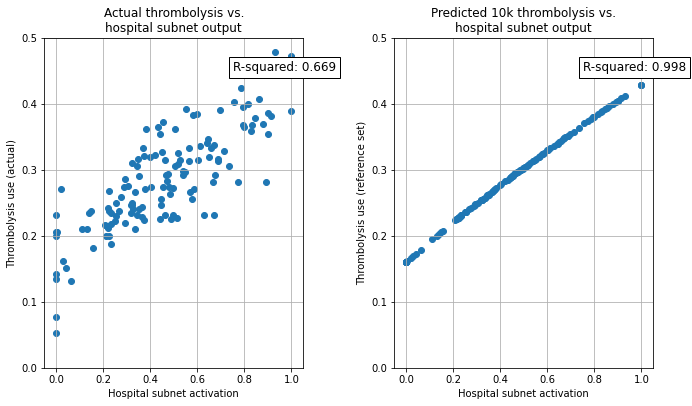

In [11]:
# Set up figure
fig = plt.figure(figsize=(10,6))

# Plot 1: actual vs subnet
ax1 = fig.add_subplot(121)
ax1.scatter(predicted_thrombolysis['hosp_subnet_output'],
           predicted_thrombolysis['actual_thrombolysis'])
ax1.set_xlabel('Hospital subnet activation')
ax1.set_ylabel('Thrombolysis use (actual)')
correlation = predicted_thrombolysis.corr()
r_square_model = \
    correlation['hosp_subnet_output']['actual_thrombolysis'] ** 2
text = f'R-squared: {r_square_model:0.3f}'
ax1.text(0.75, 0.45, text, fontsize=12, bbox=dict(facecolor='w', alpha=1.0))
ax1.set_ylim(0,0.5)
ax1.set_title('Actual thrombolysis vs.\nhospital subnet output')
ax1.grid()

# Plot 2: 10k vs subnet
ax2 = fig.add_subplot(122)
ax2.scatter(predicted_thrombolysis['hosp_subnet_output'],
           predicted_thrombolysis['10k_thrombolysis'])
ax2.set_xlabel('Hospital subnet activation')
ax2.set_ylabel('Thrombolysis use (reference set)')
correlation = predicted_thrombolysis.corr()
r_square_model = \
    correlation['hosp_subnet_output']['10k_thrombolysis'] ** 2
text = f'R-squared: {r_square_model:0.3f}'
ax2.text(0.75, 0.45, text, fontsize=12, bbox=dict(facecolor='w', alpha=1.0))
ax2.set_ylim(0,0.5)
ax2.set_title('Predicted 10k thrombolysis vs.\nhospital subnet output')
ax2.grid()

plt.tight_layout(pad=2)
plt.savefig('./output/hospital_reference_thrombolysis.jpg', dpi=300)
plt.show()

We can see that the hospital subnet output correlates with the actual use of thrombolysis at each hospital (R-Squared 0.669), but with some scatter. The scatter will be due to factors other than hospital thrombolysis decision making effecting final thrombolysis use (such as differences in patient populations attending each hospital). When subnet activation is compared to predicted thrombolysis use of the same patients passing through all hospitals, the correlation between hospital subnet activation (which is embedded in the model during training, and is not effected by the test patients) is virtually perfect (R-Squared 0.996).

The results show:

1) Hospital subnet output, fixed during network training, is very closely correlated with the thrombolysis use of a fixed set of patients passed through all hospitals. Hospital subnet output may therefore be used as a measure of "willingness to thrombolyse", with hospitals ranked in tendency to use thrombolysis by this subnet output value.

2) Hospital subnet output (hospital-level decision-making) explains a significant proportion, but not all, of the inter-hospital variation in use of thrombolysis.

NOTE: Here the subnet activation is inversely proportional to the use of thrombolysis. This may seem counter-intuitive, but it is due to the way neural networks optimise. There is no need for networks to optimise to have direct proportionality throughout the networks; the direction of relationship may be switched at each layer.

## Examine clinical subnet output

In this section we examine the output of the clinical subnet. This subnet is patient-specific, but excludes pathway data (such as day/time of arrival, time since stroke, time of scan, etc).The output is therefore dependent on patient clinical characteristics, but is not dependent on which hospital a patient attended or dependent on pathway data.

### Get clincial subnet output for 10k patients

This code gets the output directly from the clinical subnet in the neural network. We store this with all patient characteristics (the loaded test set data).

In [12]:
# Get patient subnet output
layer_name = 'patient_encode'
patient_encode_model = keras.Model(
    inputs=model.input,outputs=model.get_layer(layer_name).output)
patient_encode_output = patient_encode_model([
    X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])

# Put in DataFrame with all patient characteristics (X)
clinical_subnet_output = test.copy()
clinical_subnet_output['patient_subnet_output'] = \
    patient_encode_output.numpy().flatten()

clinical_subnet_output['num_hosp_thrombolysising'] = \
    np.sum(patient_results, axis=0).flatten()

# Sort by patient_subnet_output
clinical_subnet_output.sort_values('patient_subnet_output', inplace=True)

### Show relationship between clinical subnet output and proportion of patients receiving thrombolysis

Here we test the relationship between the output of the clinical subnet and the actual use of thrombolysis. We do this by binning the output of the clinical subnets into 10 bins (each representing a range of 0.1 in the clinical subnet output), and taking the average use of thrombolysis in that bin.

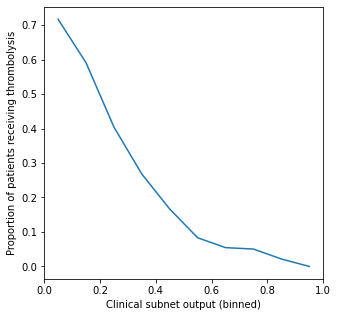

In [13]:
subnet_values = clinical_subnet_output['patient_subnet_output'].values
subnet_values = subnet_values * 10
clinical_subnet_output['subnet_bin'] = subnet_values.astype(int)/10 + 0.05


rx = clinical_subnet_output.groupby('subnet_bin').mean()['S2Thrombolysis']
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(rx.index, rx.values)
ax.set_xlabel('Clinical subnet output (binned)')
ax.set_xlim(0,1)
ax.set_ylabel('Proportion of patients receiving thrombolysis')
plt.savefig('./output/clinical_subnet_thrombolysis.jpg', dpi=300)
plt.show()

We observe a clear relationship between the clinical subnet output and the use of thrombolysis - those patients with the highest clinical subnet output have a little over 70% use of thrombolysis.

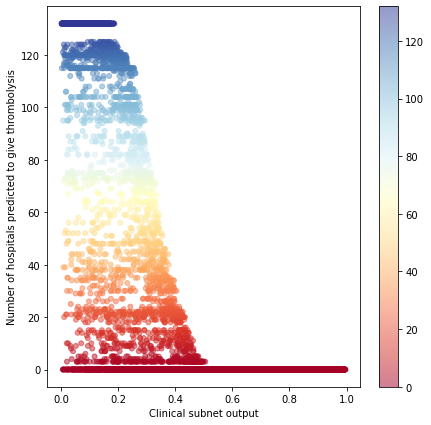

In [14]:
patient_thromb_results = np.sum(patient_results, axis=0).flatten()
# Set up figure
fig = plt.figure(figsize=(7,7))
cm = plt.cm.get_cmap('RdYlBu')
# Plot 1: actual vs subnet
ax1 = fig.add_subplot(111)
im = ax1.scatter(clinical_subnet_output['patient_subnet_output'],
                 clinical_subnet_output['num_hosp_thrombolysising'] ,
                 c=clinical_subnet_output['num_hosp_thrombolysising'] ,
                 vmin=0, vmax=132, s=25, cmap=cm, alpha=0.5)
ax1.set_xlabel('Clinical subnet output')
ax1.set_ylabel('Number of hospitals predicted to give thrombolysis')
plt.colorbar(im, ax=ax1)
plt.savefig('./output/clinical_subnet_thrombolysis_scatter.jpg', dpi=300)
plt.show()

### Show some clinical subnet outputs by patient type

Here we look at the relationships between some clinical features and the clinical subnet output.

#### Show patient_subnet_output by stroke type

In [15]:
clinical_subnet_output.groupby('S2StrokeType_Infarction').mean()['patient_subnet_output']

S2StrokeType_Infarction
0    0.960485
1    0.360709
Name: patient_subnet_output, dtype: float32

Those patients with an infarction (clot) have, on average, a much higher clinical subnet output than those without infarction (bleed, or type-unknown).

#### Show patient_subnet_output by age group

In [16]:
clinical_subnet_output.groupby('MoreEqual80y_Yes').mean()['patient_subnet_output']

MoreEqual80y_Yes
0    0.435559
1    0.481998
Name: patient_subnet_output, dtype: float32

Those patients aged 80 or over have a little lower clinical subnet output than those aged under 80.

#### Show relationship between NIHSS arrival and clinical_subnet_output

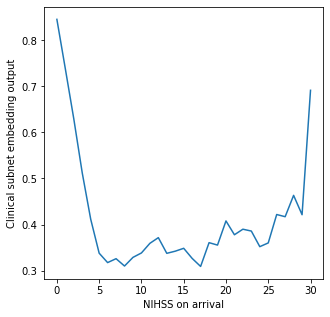

In [17]:
nihss = clinical_subnet_output.groupby('S2NihssArrival').mean()['patient_subnet_output']
# Limit plot to NIHSS of 30 or less, as less than 20 in each group above this
mask = nihss.index <=30
nihss = nihss[mask]
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(nihss.index, nihss.values)
ax.set_xlabel('NIHSS on arrival')
ax.set_ylabel('Clinical subnet embedding output')
plt.savefig('./output/clinical_subnet_nihss.jpg', dpi=300)
plt.show()

Clinical subnet output is low for patients with low or high NIHSS on arrival.

#### Show relationship between modifed Rankin Scale and clinical_subnet_output

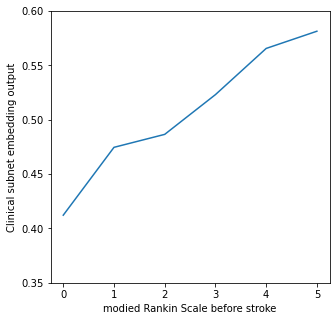

In [18]:
rankin = clinical_subnet_output.groupby('S2RankinBeforeStroke').mean()['patient_subnet_output']
# Limit plot to NIHSS of 30 or less, as less than 20 in each group above this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(rankin.index, rankin.values)
ax.set_xlabel('modied Rankin Scale before stroke')
ax.set_ylabel('Clinical subnet embedding output')
ax.set_ylim(0.35,0.6)
plt.savefig('./output/clinical_subnet_rankin.jpg', dpi=300)
plt.show()

Clinical subnet output falls with increasing disability before stroke.

## Observations

Using subnets for different types of data increased model accuracy (previously described). But subnets also provide insight into both hospitals and patients. The subnets allow ranking of hospitals in likelihood to use thrombolysis (independent of patients) and allow ranking of patient clinical characteristics in suitability for thrombolysis.